In [5]:
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [6]:
tsteps = 1024

1024

# Import Data

In [24]:
def load_config(file_path, grid_size, sample, broad = False):
    if broad:
        file = open(file_path+"Ising_broad_"+str(grid_size)+"_"+str(sample)+".pickle", 'rb')
    else:
        file = open(file_path+"Ising"+str(grid_size)+"_"+str(sample)+".pickle", 'rb')
    return pickle.load(file)

In [22]:
file_path = "C:\\Users\\Ryan\\Documents\\Github\\Masters_Vogt_AMATH563_Final\\"
test = load_config(file_path, 4, 2)
broad = True

# Calculate SVDs

In [6]:
u, s, v = np.linalg.svd(test['State'][0])
print(np.shape(v))

(256, 256)


In [36]:
def calc_svds(file_path, size, broad=False):
    sing_list = []
    u_list = []
    v_list = []
    broad = False
    temps = load_config(file_path, size, 1, broad = broad)['Temperature']

    for i in range(10):
        sings = np.zeros([size*size, 0])
        us = []
        vs = []
        sample = load_config(file_path, size, i+1)
        for data in tqdm(sample['State']):
            u ,s,v = np.linalg.svd(data)
            sings = np.append(sings, np.expand_dims(s,-1), axis = 1)
            us.append(u)
            vs.append(v)
        sing_list.append(sings)
        u_list.append(us)
        v_list.append(vs)
    return u_list, sing_list, v_list

In [38]:
us, sings, vs = calc_svds(file_path, 4, True)

100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  7.80it/s]


In [19]:
np.shape(X)

(1024, 200)

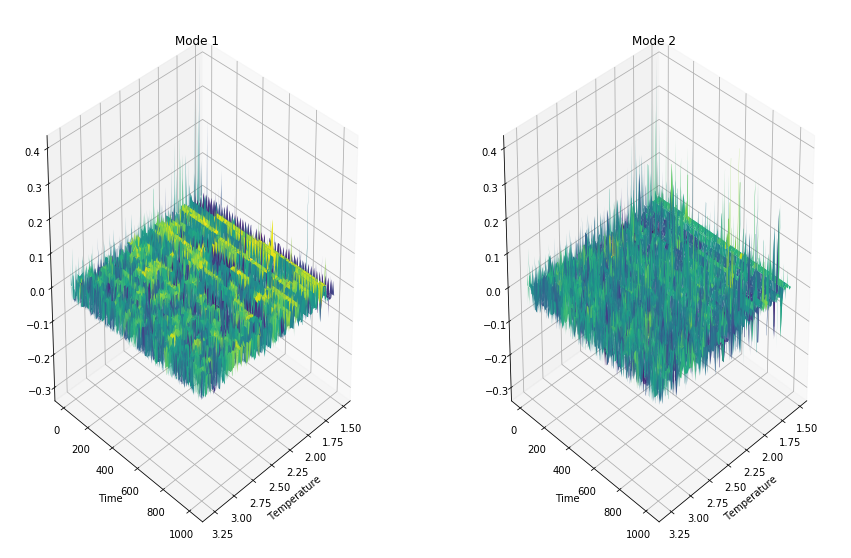

In [27]:
fig = plt.figure(figsize =(15,10))
ax1 = plt.subplot(121, projection = '3d')
x = temps
y = np.linspace(1, tsteps, tsteps)
X,Y = np.meshgrid(x,y)
z1 = np.array(u_list[0])[:,0, :]
ax1.plot_surface(X, Y, z1.T, edgecolor='none', cmap='viridis')
plt.xlabel('Temperature')
plt.ylabel('Time')
plt.title('Mode 1')
ax1.view_init(30,45)

# ax2 = plt.axes(projection = '3d')
ax2 = plt.subplot(122, projection = '3d')
z2 = np.array(u_list[0])[:,1, :]
ax2.plot_surface(X, Y, z2.T, edgecolor='none', cmap='viridis')
plt.xlabel('Temperature')
plt.ylabel('Time')
plt.title('Mode 2')
ax2.view_init(30,45)

In [29]:
smsum = np.zeros([size*size, len(sample['Temperature'])])
for sm in sing_list:
    smsum = smsum + sm
smsum = smsum/len(sing_list)

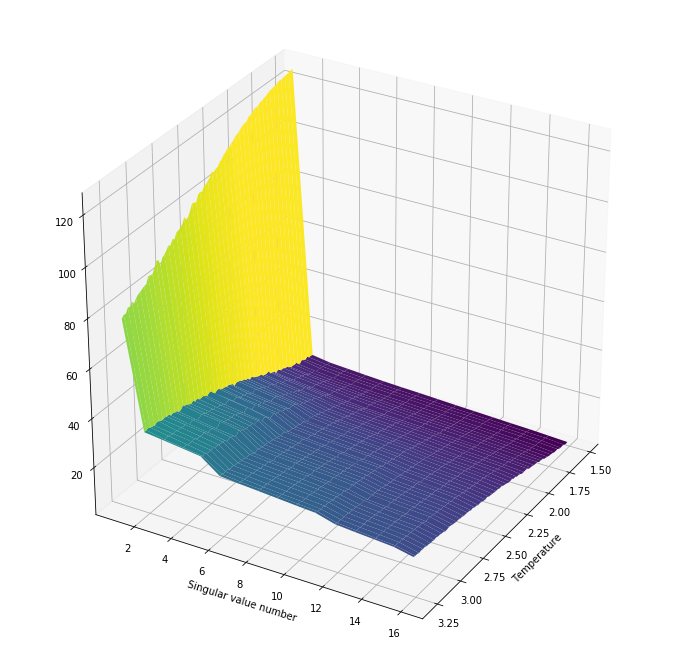

In [35]:
fig = plt.figure(figsize =(12,12))
ax = plt.axes(projection = '3d')
x = temps
y = np.linspace(1, size**2, size**2)
X,Y = np.meshgrid(x,y)
ax.plot_surface(X, Y, smsum, edgecolor='none', cmap='viridis', shade = True)
plt.xlabel('Temperature')
plt.ylabel('Singular value number')
ax.view_init(30,30)


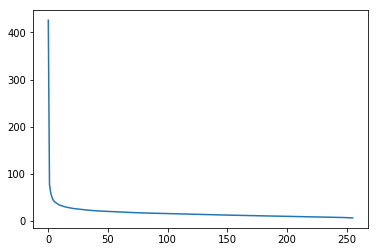

In [52]:
# plt.plot(test['Temperature'], smsum[:, 0])
plt.plot([range(size*size)][0], smsum[:, 30])

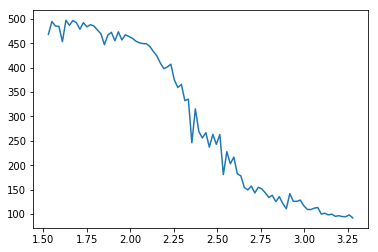

In [106]:
plt.plot(test['Temperature'], sings[0, :])

496.98506697534356